In [1]:
import numpy as np
train_set = np.load('../data/ml_data/HG002_2_3_00_train.npz')
train_set.files

['features', 'labels', 'read_ids']

In [3]:
features = train_set['features']
features.shape

(5120000, 6, 15)

In [14]:
features[0]

# ACGT, base quality, m6a score (dorado output normalized)
# left to right (7 before - central - 7 after)
# 7 or less

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 1.        , 1.        , 0.        ,
        1.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 1.        ],
       [0.01568627, 0.01568627, 0.01960784, 0.02745098, 0.02745098,
        0.01960784, 0.01568627, 0.01568627, 0.01568627, 0.01568627,
        0.01568627, 0.01568627, 0.01960784, 

In [9]:
# compare base quality
print(np.min(features[:, 4, :]))
print(np.max(features[:, 4, :]))

0.00392156862745098
0.19607843137254902


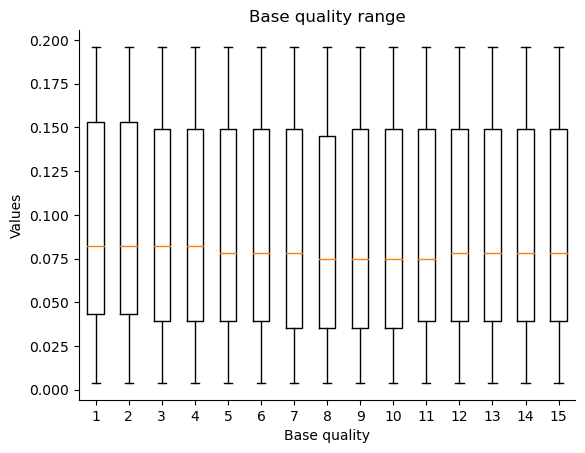

In [11]:
import matplotlib.pyplot as plt

data_to_plot = features[:, 4, :]

plt.boxplot(data_to_plot)

plt.xlabel('Base quality')
plt.ylabel('Values')
plt.title('Base quality range')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [16]:
above_threshold_mask = features[:, 4, :] > 0.05
all_above_threshold = np.all(above_threshold_mask, axis=1)
np.sum(all_above_threshold)

2616972

In [18]:
2616972/5120000 * 100

51.112734375

In [14]:
labels = train_set['labels']
labels.shape

(5120000,)

In [15]:
np.unique(labels, return_counts=True)
# balanced dataset

(array([0, 1]), array([2560000, 2560000]))

In [12]:
read_ids = train_set['read_ids']
read_ids.shape

(5120000,)

In [13]:
print(len(np.unique(read_ids)))
np.unique(read_ids)

213836


array(['00001f28-63a9-44bf-8585-d7e23cad8efc',
       '00005361-7da2-4a05-a62e-1794cb70db88',
       '000140f5-10c8-45e0-8aad-30765d03cfcc', ...,
       'fffef1e8-4f96-4460-8a52-c2e7b72c1c9b',
       'ffff1f6a-61ee-4e0d-98fe-936c6e7f73a3',
       'ffff8788-d23d-4289-aded-53e8cd0264fb'], dtype='<U36')

In [2]:
# filtering

def filter_set_by_base_quality(data, quality_threshold = 0.05, drop_base_quality = True):
    features = data['features']
    labels = data['labels']
    
    above_threshold_mask = features[:, 4, :] > quality_threshold
    all_above_threshold_features = np.all(above_threshold_mask, axis=1)
    
    if drop_base_quality:
        mask = np.arange(features.shape[1]) != 4
        all_above_threshold_features = features[:, mask, :]
        
    all_above_threshold_labels = labels[all_above_threshold_features]
    
    return all_above_threshold_features, all_above_threshold_labels

features, labels = filter_set_by_base_quality(train_set)

In [ ]:
len(labels)

In [ ]:
# basic lstm architecture
import torch
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, bidirectional=False):
        super(LSTMClassifier, self).__init__()
        
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, bidirectional=bidirectional, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        
        return out